## *Faster* Gaussian processes

One of the major constraints that limits the utility of Gaussian processes in practice is the inversion of $K$ when calculating the posterior covariance. Since it is evaluated at every observed data point, its execution time is $\mathcal{O(n^3)}$, which makes Gaussian processes (in the form I have presented here) impractical for larger datasets.

An approach for dealing with this computation complexity is to look for an approximation to accelerate training and prediction. For Gaussian processes, this can be accomplished by employing a **sparse approximation** to the Gram matrix that places $M<<N$ *inducing points* along the range of the input variables, and uses this to estimate the full covariance matrix for the observed points. 

The `gp.MarginalSparse` class implements sparse, or inducing point, GP approximations.  It works identically to `gp.Marginal`, except it additionally requires the locations of the inducing points (denoted `Xu`), and it accepts the argument `sigma` instead of `noise` because these sparse approximations assume white IID noise.

The downside of sparse approximations is that they reduce the expressiveness of the GP.  Reducing the dimension of the covariance matrix effectively reduces the number of covariance matrix eigenvectors that can be used to fit the data.  

A choice that needs to be made is where to place the inducing points.  One option is to use a subset of the inputs.  Another possibility is to use K-means.  The location of the inducing points can also be an unknown and optimized as part of the model.  These sparse approximations are useful for speeding up calculations when the density of data points is high and the lengthscales is larger than the separations between inducing points. 

### Dense dataset

For the following examples, we use the same data set as was used in the `gp.Marginal` example, but with **more** simulated data.

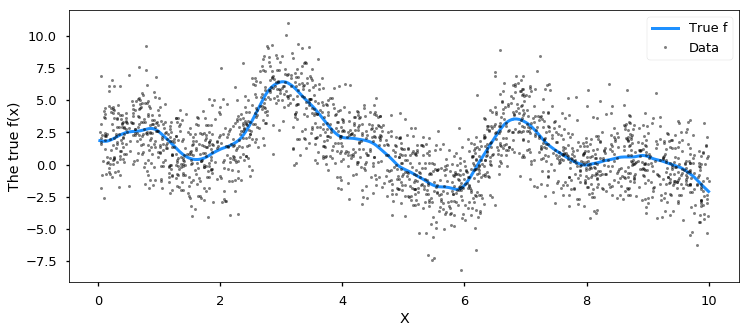

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.cm as cmap
sns.set_context('talk')

# set the seed
np.random.seed(42)

n = 2000 # The number of data points
X = 10*np.sort(np.random.rand(n))[:,None]

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

We can specify a sparse marginal likelihood model via `MarginalSparse`, where the approximation method can be chosen. We will use the **fully independent training conditional (FITC)** algorithm to estimate the model, with the critical approximation being the imposition of a conditional independence assumption on the joint prior over training and test cases.

In [2]:
with pm.Model() as sparse_model:
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

We next need a set of inducing points. We will initialize 20 inducing points with the **K-means** algorithm.

In [3]:
with sparse_model:
    
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

From here, we use the `marginal_likelihood` method, just as we did with the full GP.

In [4]:
with sparse_model:
    
    σ = pm.HalfCauchy("σ", beta=5)
    obs = gp.marginal_likelihood("obs", X=X, Xu=Xu, y=y, sigma=σ)
    
    trace = pm.sample(1000, njobs=1, chains=1, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:51<00:00, 29.01it/s]


In [5]:
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with sparse_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with sparse_model:
    pred_samples = pm.sample_ppc(trace, vars=[f_pred], samples=500)

100%|██████████| 500/500 [00:13<00:00, 42.41it/s]


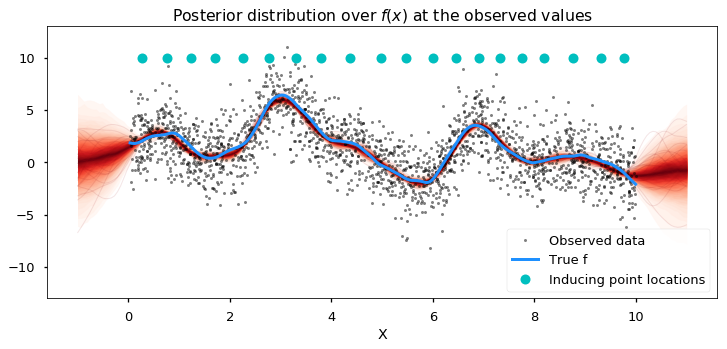

In [6]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "co", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

### Multidimensional GP

Until now, our examples have been of 1-dimensional Gaussian processes, where there is just a single predictor variable thought to have a non-linear relationship to the outcome. Let's look at a real-world dataset that involves two predictors. 

We will use the famous **Walker Lake dataset (Isaaks & Srivistava 1989)** that involves spatial sampling of minerals and other variables over space. The data consist of two spatial coordinates and three measured outcomes. The outcomes are anonymously labeled as U, V (continuous variables, such as concentrarion) and T (discrete variable, such as the presence of a particular element). 

In [7]:
import pandas as pd

walker_data = pd.read_table('data/walker.txt', sep='\s+', index_col=0, skiprows=8, header=None, 
              names=['ID', 'Xloc', 'Yloc', 'V', 'U', 'T'])
walker_data.head()

,Xloc,Yloc,V,U,T
ID,,,,,
1,11,8,0.0,1.000000e+31,2
2,8,30,0.0,1.000000e+31,2
3,9,48,224.4,1.000000e+31,2
4,8,69,434.4,1.000000e+31,2
5,9,90,412.1,1.000000e+31,2


The samples are taken regularly over a coarse grid across the entire area, and then irregularly over portions of the area, presumably where there were positive samples on the coarser grid. 

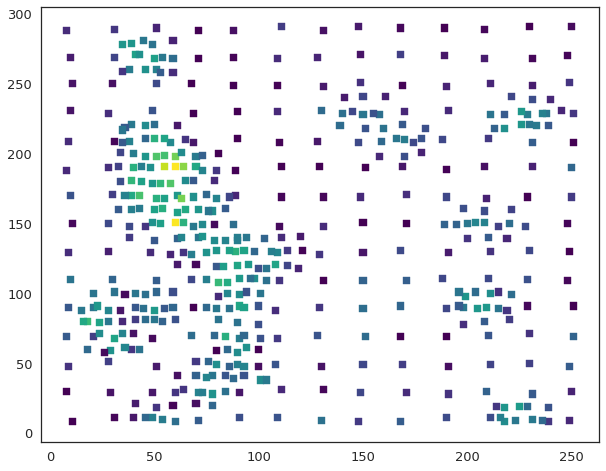

In [8]:
nx = 40
x1, x2 = np.meshgrid(np.linspace(0,300,nx), np.linspace(0,300,nx))
X = np.concatenate([x1.reshape(nx*nx, 1), x2.reshape(nx*nx, 1)], 1)

X_obs = walker_data[['Xloc', 'Yloc']].values
y_obs = walker_data.V.values

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(X_obs[:,0], X_obs[:,1], s=50, c=y_obs, marker='s', cmap=plt.cm.viridis);

We need a sparse grid of inducing points:

In [9]:
nd = 15
xu1, xu2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1)

With two predictor variables (spatial coordinates), we specify two input dimensions (`input_dim`) for our covariance function, here a quadratic exponential.

In [10]:
with pm.Model() as spatial_model:
    
    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)
    sn2 = pm.HalfCauchy("sn2", beta=3)

    K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    
    gp_spatial = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    obs = gp_spatial.marginal_likelihood("obs", X=X_obs, Xu=Xu, y=y_obs, sigma=sn2)

    mp = pm.find_MAP()

logp = -3,304.5, ||grad|| = 0.037952: 100%|██████████| 45/45 [00:01<00:00, 25.14it/s]      


We can use this model to characterize the landscape at a finer scale, by specifying grid to predict on and passing it to the `conditional` method.

In [11]:
nd = 30
z1, z2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Z = np.concatenate([z1.reshape(nd*nd, 1), z2.reshape(nd*nd, 1)], 1)

with spatial_model:

    f_pred = gp_spatial.conditional('f_pred', Z)
    
    samples = pm.sample_ppc([mp], vars=[f_pred], samples=100)

100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


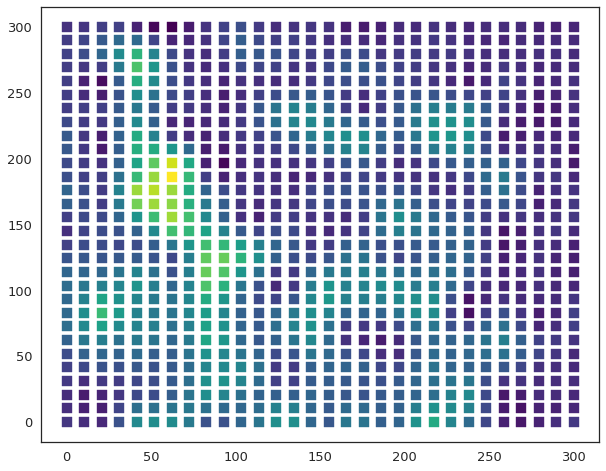

In [12]:
with sns.axes_style("white"):

    plt.figure(figsize=(10,8))
    plt.scatter(z1.flatten(), z2.flatten(), s=100, c=samples['f_pred'].mean(0), marker='s', cmap=plt.cm.viridis);

---

## References

- [Quinonero-Candela, J. & Rasmussen, C. E. (2005). A Unifying View of Sparse Approximate Gaussian Process Regression
Journal of Machine Learning Research 6, 1939–1959.](http://www.jmlr.org/papers/v6/quinonero-candela05a.html)